In [77]:
# import libraries
import os
import random

import pandas as pd
import numpy as np

import torch
from torchvision import datasets, models
from torchvision.transforms import v2
from PIL import Image
import tqdm
import matplotlib.pyplot as plt

# **Set HyperParameters**

In [56]:
# configs
CFG = {
    "seed": 42,
    "img_size": 224,
    "batch_size": 32,
    "num_workers": 8,
    "num_epochs": 8,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    "mean": [0.485, 0.456, 0.406], 
    "std": [0.229, 0.224, 0.225]
}
toImage = lambda img_batch: (img_batch.permute(1,2,0).cpu().numpy()* np.array(CFG["std"]) + np.array(CFG["mean"])).clip(0, 1)

print(f"Device:", CFG["device"])

Device: cuda


### **Make Deterministic**

In [57]:
# set deterministic randoms
random.seed(CFG["seed"])
np.random.seed(CFG["seed"])
torch.manual_seed(CFG["seed"])
torch.cuda.manual_seed_all(CFG["seed"])
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [58]:
INPUT_DIR = os.path.join('/', 'kaggle','input')
DATASET_NAME = os.listdir(INPUT_DIR)[0]
DATASET_DIR = os.path.join(INPUT_DIR, DATASET_NAME)

test_path = os.path.join(DATASET_DIR,'test')
train_path = os.path.join(DATASET_DIR,'train')
val_path = os.path.join(DATASET_DIR, 'validation')

if os.path.exists(test_path) and os.path.exists(train_path) and os.path.exists(val_path):
    print(f'All directories found.')
else:
    raise FileNotFoundError(f'Directories:\n\tTest ({test_path}): {os.path.exists(test_path)};\n\tTrain ({train_path}): {os.path.exists(train_path)};\n\tValidation ({val_path}): {os.path.exists(val_path)};')

All directories found.


In [59]:
# transforms to train and validation datasets
train_transforms = v2.Compose([
    v2.ToImage(),
    v2.RandomResizedCrop(size=(CFG['img_size'], CFG['img_size']), antialias=True),
    v2.RandomHorizontalFlip(p = 0.5),
    # v2.RandomRotation(degrees=(-15, 15)),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=CFG['mean'], std=CFG['std']),
])
val_transforms = v2.Compose([
    v2.ToImage(),
    v2.Resize(size=(int(CFG['img_size'] * 1.1),), antialias=True), 
    v2.CenterCrop(size=(CFG['img_size'], CFG['img_size'])),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=CFG['mean'], std=CFG['std']),
])

In [60]:
train_dataset = datasets.ImageFolder(train_path, transform = train_transforms)

val_dataset = datasets.ImageFolder(val_path, transform = val_transforms)
test_dataset = datasets.ImageFolder(test_path, transform = val_transforms)

test_dataset, train_dataset, val_dataset

(Dataset ImageFolder
     Number of datapoints: 359
     Root location: /kaggle/input/fruit-and-vegetable-image-recognition/test
     StandardTransform
 Transform: Compose(
                  ToImage()
                  Resize(size=[246], interpolation=InterpolationMode.BILINEAR, antialias=True)
                  CenterCrop(size=(224, 224))
                  ToDtype(scale=True)
                  Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], inplace=False)
            ),
 Dataset ImageFolder
     Number of datapoints: 3115
     Root location: /kaggle/input/fruit-and-vegetable-image-recognition/train
     StandardTransform
 Transform: Compose(
                  ToImage()
                  RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333333333333333), interpolation=InterpolationMode.BILINEAR, antialias=True)
                  RandomHorizontalFlip(p=0.5)
                  ToDtype(scale=True)
                  Normalize(mean=[0.485, 0.456, 0.406], 

In [61]:
# load the data
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size = CFG["batch_size"],
    shuffle = True, num_workers = CFG['num_workers']
)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size = CFG["batch_size"],
    shuffle = False, num_workers = CFG['num_workers']
)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size = CFG["batch_size"],
    shuffle = False, num_workers = 0
)
len(train_dataloader), len(val_dataloader), len(test_dataloader),

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


(98, 11, 12)

In [62]:
if train_dataset.classes == val_dataset.classes == test_dataset.classes:
    label_names = train_dataset.classes
    num_classes = len(label_names)
    print(f'All label names: {label_names}')
    print(f'\nNumber of labels: {num_classes}')
else:
    raise ValueError("Different Class Names")

All label names: ['apple', 'banana', 'beetroot', 'bell pepper', 'cabbage', 'capsicum', 'carrot', 'cauliflower', 'chilli pepper', 'corn', 'cucumber', 'eggplant', 'garlic', 'ginger', 'grapes', 'jalepeno', 'kiwi', 'lemon', 'lettuce', 'mango', 'onion', 'orange', 'paprika', 'pear', 'peas', 'pineapple', 'pomegranate', 'potato', 'raddish', 'soy beans', 'spinach', 'sweetcorn', 'sweetpotato', 'tomato', 'turnip', 'watermelon']

Number of labels: 36


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


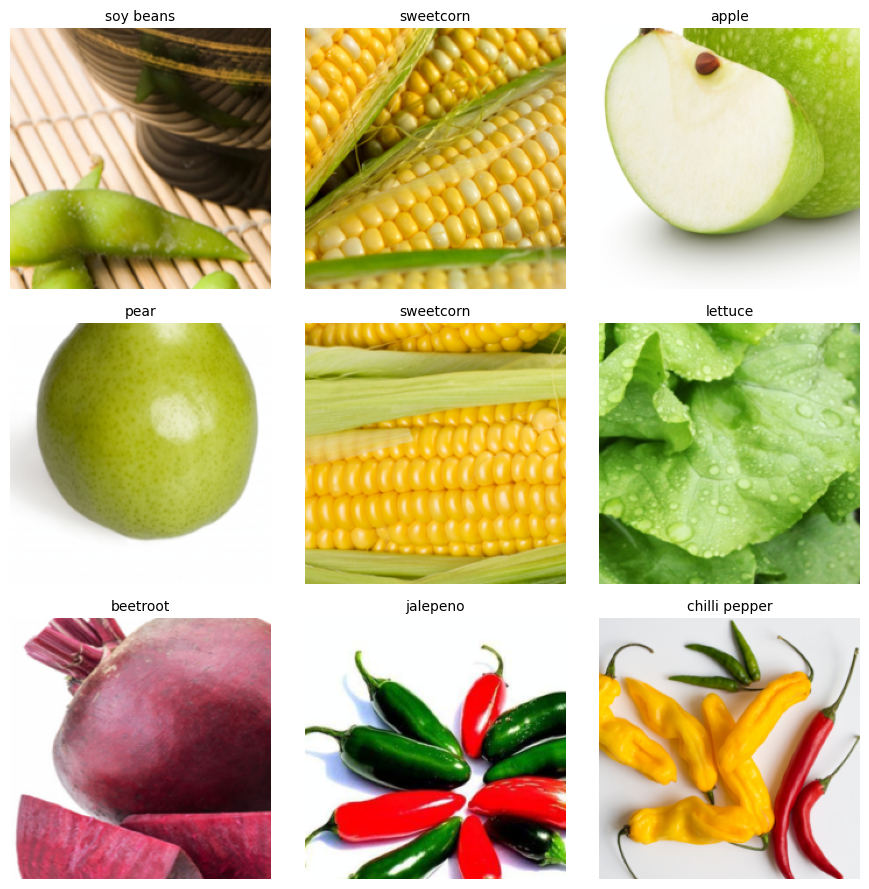

In [63]:
def show_images(loader, n=12, cols=4):
    X_batch, y_batch = next(iter(loader))

    n = min(n, len(X_batch))
    rows = (n + cols - 1) // cols

    plt.figure(figsize=(3*cols, 3*rows))
    for i in range(n):
        img, label = toImage(X_batch[i]), label_names[y_batch[i].item()]
        
        plt.subplot(rows, cols, i+1)
        plt.imshow(img)
        plt.title(label, fontsize=10)
        plt.axis("off")

    plt.tight_layout()
    plt.show()
show_images(train_dataloader, n=9, cols=3)

In [64]:
from tqdm import tqdm
import torch

def train_model(model, criterion, optimizer, scheduler, num_epochs, device):
    model = model.to(device)
    artifacts = {
        "train": {"loss": [], "accuracy": []},
        "val":   {"loss": [], "accuracy": []},
    }

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")

        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
                dataloader = train_dataloader
            else:
                model.eval()
                dataloader = val_dataloader

            running_loss = 0.0
            running_correct = 0
            running_total = 0

            for X, y in tqdm(dataloader, desc=phase):
                X = X.to(device)
                y = y.to(device)

                if phase == "train":
                    optimizer.zero_grad(set_to_none=True)

                with torch.set_grad_enabled(phase == "train"):
                    logits = model(X)
                    loss = criterion(logits, y)
                    preds = logits.argmax(dim=1)

                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                bs = y.size(0)
                running_loss += loss.item() * bs
                running_correct += (preds == y).sum().item()
                running_total += bs

            epoch_loss = running_loss / running_total
            epoch_acc  = running_correct / running_total

            artifacts[phase]["loss"].append(epoch_loss)
            artifacts[phase]["accuracy"].append(epoch_acc)

            print(f"{phase}: loss={epoch_loss:.4f} acc={epoch_acc:.4f}")

        if scheduler is not None:
            scheduler.step()

    return model, artifacts

In [65]:
model = models.resnet34(
    weights=models.ResNet34_Weights.IMAGENET1K_V1
)

for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Sequential(
    torch.nn.Linear(model.fc.in_features, 256),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.3),
    torch.nn.Linear(256, num_classes)
)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(
    model.parameters(), 
    lr = 1e-3,
    weight_decay=1e-4
)
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size = 7,
    gamma = 0.1
)

In [66]:
model, artifacts = train_model(
    model = model,
    criterion = criterion,
    optimizer = optimizer,
    scheduler = scheduler, 
    num_epochs = CFG['num_epochs'], 
    device = CFG['device']
)


Epoch 1/8


train:   0%|          | 0/98 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train:  27%|██▋       | 26/98 [00:17<00:42,  1.70it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train:  41%|████      | 40/98 [00:24<00:15,  3.63it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train:  73%|███████▎  | 72/98 [00:39<00:12,  2.14it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images wi

train: loss=2.5783 acc=0.3512


val: 100%|██████████| 11/11 [00:12<00:00,  1.14s/it]


val: loss=0.9839 acc=0.7949

Epoch 2/8


train:   0%|          | 0/98 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train:   8%|▊         | 8/98 [00:09<01:24,  1.07it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train:  13%|█▎        | 13/98 [00:10<00:35,  2.41it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train:  37%|███▋      | 36/98 [00:23<00:24,  2.58it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images wit

train: loss=1.3152 acc=0.6408


val: 100%|██████████| 11/11 [00:12<00:00,  1.13s/it]


val: loss=0.5417 acc=0.8433

Epoch 3/8


train:  14%|█▍        | 14/98 [00:09<00:29,  2.80it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train:  26%|██▌       | 25/98 [00:16<00:29,  2.44it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train:  50%|█████     | 49/98 [00:28<00:11,  4.44it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train:  58%|█████▊    | 57/98 [00:34<00:18,  2.23it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette 

train: loss=1.0431 acc=0.6886


val: 100%|██████████| 11/11 [00:12<00:00,  1.12s/it]


val: loss=0.4524 acc=0.8746

Epoch 4/8


train:   0%|          | 0/98 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train:   9%|▉         | 9/98 [00:10<01:23,  1.06it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train:  56%|█████▌    | 55/98 [00:30<00:12,  3.36it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted 

train: loss=0.9099 acc=0.7271


val: 100%|██████████| 11/11 [00:12<00:00,  1.13s/it]


val: loss=0.4090 acc=0.8917

Epoch 5/8


train:   0%|          | 0/98 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train:  24%|██▍       | 24/98 [00:16<00:23,  3.10it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train:  36%|███▌      | 35/98 [00:20<00:15,  4.17it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train:  39%|███▉      | 38/98 [00:23<00:33,  1.80it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images wi

train: loss=0.8394 acc=0.7429


val: 100%|██████████| 11/11 [00:12<00:00,  1.13s/it]


val: loss=0.3654 acc=0.8718

Epoch 6/8


train:   0%|          | 0/98 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train:   7%|▋         | 7/98 [00:06<00:38,  2.37it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train:  26%|██▌       | 25/98 [00:17<00:23,  3.12it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train:  71%|███████▏  | 70/98 [00:38<00:08,  3.16it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images wit

train: loss=0.7674 acc=0.7570


val: 100%|██████████| 11/11 [00:12<00:00,  1.14s/it]


val: loss=0.3211 acc=0.8832

Epoch 7/8


train:   0%|          | 0/98 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train:   7%|▋         | 7/98 [00:07<00:58,  1.55it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train:  17%|█▋        | 17/98 [00:14<00:56,  1.44it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train:  27%|██▋       | 26/98 [00:19<00:44,  1.62it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train:  32%|███▏      | 31/98 [00:20<00:21,  3.11it/s]/usr/local/lib/python3.12/dist-packa

train: loss=0.7581 acc=0.7608


val: 100%|██████████| 11/11 [00:12<00:00,  1.13s/it]


val: loss=0.3498 acc=0.8746

Epoch 8/8


train:   8%|▊         | 8/98 [00:07<00:42,  2.11it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train:  19%|█▉        | 19/98 [00:12<00:27,  2.91it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train:  20%|██        | 20/98 [00:15<01:01,  1.27it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train:  31%|███       | 30/98 [00:18<00:26,  2.55it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train:  36%|███▌      | 35/98 [00:20<00:21,  2.98it/s]/usr/local/lib/python3.12/d

train: loss=0.6756 acc=0.7830


val: 100%|██████████| 11/11 [00:12<00:00,  1.11s/it]

val: loss=0.2821 acc=0.9259


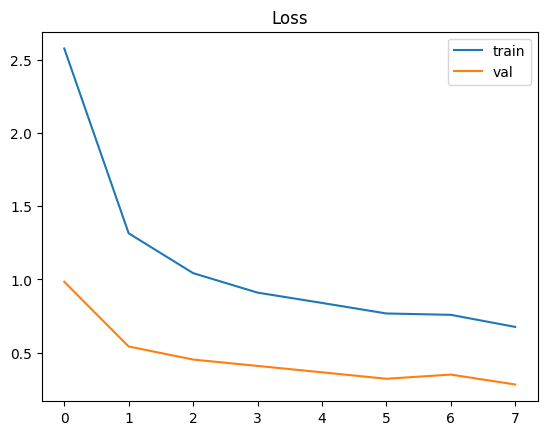

In [70]:
plt.plot(artifacts['train']['loss'], label = 'train')
plt.plot(artifacts['val']['loss'], label = 'val')
plt.title('Loss')
plt.legend() 
plt.show()

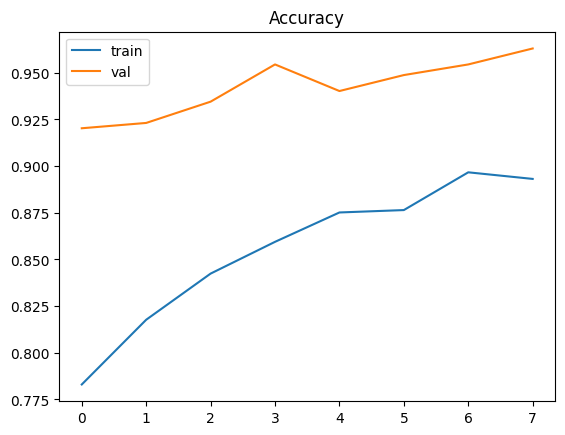

In [72]:
plt.plot(artifacts['train']['accuracy'], label = 'train')
plt.plot(artifacts['val']['accuracy'], label = 'val')
plt.title('Accuracy')
plt.legend() 
plt.show()

In [71]:
for p in model.layer4.parameters():
    p.requires_grad = True

optimizer = torch.optim.AdamW(
    list(model.fc.parameters()) + list(model.layer4.parameters()),
    lr=1e-4,
    weight_decay=1e-4
)
model, artifacts = train_model(
    model = model,
    criterion = criterion,
    optimizer = optimizer,
    scheduler = scheduler, 
    num_epochs = CFG['num_epochs'], 
    device = CFG['device']
)


Epoch 1/8


train:   1%|          | 1/98 [00:06<09:47,  6.06s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train:  10%|█         | 10/98 [00:08<00:27,  3.17it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train:  19%|█▉        | 19/98 [00:13<00:23,  3.38it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train:  33%|███▎      | 32/98 [00:19<00:19,  3.34it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train:  72%|███████▏  | 71/98 [00:39<00:06,  4.09it/s]/usr/local/lib/python3.12/d

train: loss=0.6702 acc=0.7830


val: 100%|██████████| 11/11 [00:12<00:00,  1.13s/it]


val: loss=0.2234 acc=0.9202

Epoch 2/8


train:   0%|          | 0/98 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train:   8%|▊         | 8/98 [00:05<00:26,  3.44it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train:  16%|█▋        | 16/98 [00:10<00:34,  2.37it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train:  41%|████      | 40/98 [00:22<00:14,  3.90it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train:  64%|██████▍   | 63/98 [00:32<00:08,  4.34it/s]/usr/local/lib/python3.12/dist-packa

train: loss=0.5472 acc=0.8177


val: 100%|██████████| 11/11 [00:12<00:00,  1.12s/it]


val: loss=0.2318 acc=0.9231

Epoch 3/8


train:   5%|▌         | 5/98 [00:05<00:52,  1.78it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train:   6%|▌         | 6/98 [00:05<00:44,  2.08it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train:  14%|█▍        | 14/98 [00:09<00:24,  3.46it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train:  31%|███       | 30/98 [00:17<00:17,  3.83it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train:  34%|███▎      | 33/98 [00:20<00:39,  1.67it/s]/usr/local/lib/python3.12/di

train: loss=0.4603 acc=0.8424


val: 100%|██████████| 11/11 [00:12<00:00,  1.13s/it]


val: loss=0.2068 acc=0.9345

Epoch 4/8


train:   0%|          | 0/98 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train:   1%|          | 1/98 [00:03<06:11,  3.83s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train:  10%|█         | 10/98 [00:08<00:24,  3.59it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train:  30%|██▉       | 29/98 [00:18<00:27,  2.51it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train:  34%|███▎      | 33/98 [00:21<00:46,  1.39it/s]/usr/local/lib/python3.12/dist-packa

train: loss=0.4363 acc=0.8594


val: 100%|██████████| 11/11 [00:12<00:00,  1.12s/it]


val: loss=0.1644 acc=0.9544

Epoch 5/8


train:   0%|          | 0/98 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train:   4%|▍         | 4/98 [00:04<01:00,  1.56it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train:  12%|█▏        | 12/98 [00:08<00:43,  1.97it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train:  31%|███       | 30/98 [00:18<00:28,  2.42it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train:  33%|███▎      | 32/98 [00:21<00:48,  1.37it/s]/usr/local/lib/python3.12/dist-packa

train: loss=0.3645 acc=0.8751


val: 100%|██████████| 11/11 [00:12<00:00,  1.12s/it]


val: loss=0.1679 acc=0.9402

Epoch 6/8


train:   0%|          | 0/98 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train:   1%|          | 1/98 [00:04<06:50,  4.24s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train:  24%|██▍       | 24/98 [00:13<00:19,  3.70it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train:  78%|███████▊  | 76/98 [00:42<00:08,  2.47it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train: 100%|██████████| 98/98 [00:50<00:00,  1.95it/s]


train: loss=0.3635 acc=0.8764


val: 100%|██████████| 11/11 [00:12<00:00,  1.12s/it]


val: loss=0.1462 acc=0.9487

Epoch 7/8


train:   0%|          | 0/98 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train:   8%|▊         | 8/98 [00:05<00:24,  3.64it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train:  19%|█▉        | 19/98 [00:14<00:47,  1.66it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train:  32%|███▏      | 31/98 [00:19<00:19,  3.42it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train:  36%|███▌      | 35/98 [00:21<00:23,  2.70it/s]/usr/local/lib/python3.12/dist-packa

train: loss=0.3078 acc=0.8966


val: 100%|██████████| 11/11 [00:12<00:00,  1.11s/it]


val: loss=0.1462 acc=0.9544

Epoch 8/8


train:   3%|▎         | 3/98 [00:04<01:39,  1.05s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train:  10%|█         | 10/98 [00:10<00:53,  1.65it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train:  19%|█▉        | 19/98 [00:13<00:21,  3.75it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train:  32%|███▏      | 31/98 [00:21<00:26,  2.56it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette i

train: loss=0.3218 acc=0.8931


val: 100%|██████████| 11/11 [00:12<00:00,  1.12s/it]

val: loss=0.1427 acc=0.9630


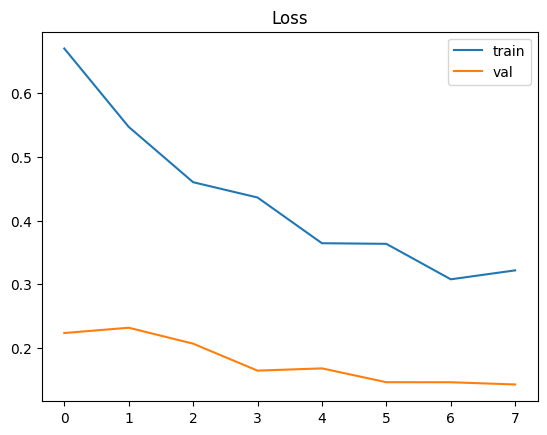

In [73]:
plt.plot(artifacts['train']['loss'], label = 'train')
plt.plot(artifacts['val']['loss'], label = 'val')
plt.title('Loss')
plt.legend() 
plt.show()

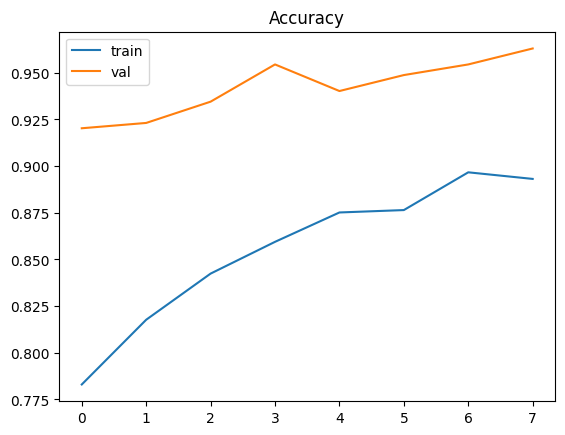

In [74]:
plt.plot(artifacts['train']['accuracy'], label = 'train')
plt.plot(artifacts['val']['accuracy'], label = 'val')
plt.title('Accuracy')
plt.legend() 
plt.show()

In [78]:
def predict_to_csv(model, loader, class_names, device, out_path="predictions.csv"):
    model.eval()
    rows = []
    idx = 0

    with torch.no_grad():
        for X, y in loader:
            X = X.to(device, non_blocking=True)
            logits = model(X)
            probs = torch.softmax(logits, dim=1)
            preds = probs.argmax(dim=1).cpu().numpy()
            confs = probs.max(dim=1).values.cpu().numpy()

            bs = preds.shape[0]
            for i in range(bs):
                rows.append({
                    "id": idx,
                    "pred_class": class_names[preds[i]],
                    "pred_id": int(preds[i]),
                    "confidence": float(confs[i]),
                })
                idx += 1

    df = pd.DataFrame(rows)
    df.to_csv(out_path, index=False)
    return df

df_preds = predict_to_csv(model, test_dataloader, train_dataset.classes, CFG["device"], "predictions.csv")
df_preds.head()

,id,pred_class,pred_id,confidence
0,0,apple,0,0.999990
1,1,apple,0,0.999990
2,2,apple,0,0.999994
3,3,apple,0,0.989507
4,4,pear,23,0.650726


In [79]:
df_preds

,id,pred_class,pred_id,confidence
0,0,apple,0,0.999990
1,1,apple,0,0.999990
2,2,apple,0,0.999994
3,3,apple,0,0.989507
4,4,pear,23,0.650726
...,...,...,...,...
354,354,watermelon,35,1.000000
355,355,watermelon,35,0.999995
356,356,watermelon,35,1.000000
357,357,watermelon,35,1.000000
